#### 1. Install the transformers module.

In [1]:
#!pip install transformers

#### 2. Open the corpus file from senseval for a word of your choice. Print the number of phrases.

In [2]:
from nltk.corpus import senseval
word = 'line'
instances = list(senseval.instances(f'{word}.pos'))
print("Number of phrases", len(instances))

Number of phrases 4146


#### 3. Print the first 10 phrases and for each phrase the definition of the target word. 

In [3]:
import nltk
nltk.data.path.append('/usr/share/nltk_data/corpora/stopwords')

In [4]:
from nltk import wsd
import nltk
from nltk.corpus import wordnet as wn
from spacy.cli import download
from spacy import load
import warnings

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')
nlp = load('en_core_web_sm')

#! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


In [5]:
from nltk.corpus import wordnet as wn

instances = senseval.instances(word + '.pos')

def features(instance):
    return ' '.join(word[0] for word in instance.context)

n = 10

sense_map = {f'{word}_{k}': wn.synset(f'{word}.n.{k:02}') for k in range(1, n+1)}
phrases = [(features(instance), instance.senses[0]) for instance in instances]

for phrase, sense in phrases[:n]:
    synset = sense_map.get(sense)
    definition = synset.definition() if synset else 'Unknown'
    print(f'Phrase: {phrase}\nSense: {sense}\nDefinition: {definition}\n')

Phrase: the company argued that its foreman needn 't have told the worker not to move the plank to which his lifeline was tied because " that comes with common sense . " the commission noted , however , that dellovade hadn 't instructed its employees on how to secure their lifelines and didn 't heed a federal inspector 's earlier suggestion that the company install special safety lines inside the a-frame structure it was building .
Sense: cord
Definition: Unknown

Phrase: the set , designed by mr . hall 's longtime associate eugene lee , has the audience divided in half , facing a central playing area . off to one side -- representing the " have-nots " of louisiana -- is a broken-down shack with a woodpile and a wash line .
Sense: cord
Definition: Unknown

Phrase: the new technology represents a considerable savings over conventional offshore production technology . the foundation of the project , a " tension-leg well platform , " will be a floating structure that is anchored to the se

#### 4. Create a DataFrame based on the sentences in the text with the columns: text, label, id. Each row will correspond to an entry in the corpus. The column text would contain the phrase from the entry (as raw text - untagged), the label will be the sense for the target word (the label should be an int), the id is the number of the phrase. Shuffle the data. For the training set, use 90% of instances to train the classifier and try to find the sense of the word on the rest of 10% of instances and compare it to the result. Print your findings. The classes used for training are the senses.

In [6]:
import pandas as pd
from nltk.classify import NaiveBayesClassifier, accuracy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


df = pd.DataFrame({
    'text': [' '.join(word[0] for word in instance.context) for instance in instances],
    'label': [instance.senses[0] for instance in instances],
    'id': range(len(instances))
})


le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

def features(text):
    return dict((word, True) for word in text.split())

classifier = NaiveBayesClassifier.train(
    [(features(row['text']), row['label']) for _, row in train_df.iterrows()]
)
predictions = [classifier.classify(features(row['text'])) for _, row in test_df.iterrows()]

accuracy_score = round(accuracy(classifier, [(features(row['text']), row['label']) for _, row in test_df.iterrows()]) * 100, 2)
print(f'Accuracy: {accuracy_score}%')

Accuracy: 79.28%


#### 5. Create a classification model from pretrained with BertForSequenceClassification. The number of labels is actually the number of classes. Set the output attentions an hidden states on false
#### 6. Use BertTokenizer from pretrained model "bert-base-uncased", in lowercase.

In [7]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(le.classes_), 
    output_attentions = False,
    output_hidden_states = False, 
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 7. Use batch_encode_plus method of the tokenizer to encode the texts. Use the longest padding and return the attention mask.

In [8]:
max_length = max([len(text.split()) for text in df['text']])

encoded_train_texts = tokenizer.batch_encode_plus(
    train_df['text'].tolist(),
    max_length=max_length,
    pad_to_max_length=True,
    return_attention_mask=True, 
    return_tensors='pt', 
)

encoded_test_texts = tokenizer.batch_encode_plus(
    test_df['text'].tolist(),
    max_length=max_length,
    pad_to_max_length=True, 
    return_attention_mask=True, 
    return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#### 8. Train the data using AdamW optimizer with a batch size of 32 and a learning rate of 5e-5.
#### 9. For each epoch load a batch and train the model with that batch (this is the step where we do the fine tunning). don't forget to use zero_grad() on the optimizer.
#### 10. Print the loss both for training and testing. Choose the number of epochs based on the values of the loss function.
#### 11. Print how much time each training epoch took.
#### 12. Classify the text based on the model you just created using the test set. You again load in batches the data and check the predictions.
#### 13. Print the accuracy, precision, recall, f1-score
#### 14. Plot the confusion matrix.
#### 15. Change the code so that the computations are made on GPU (for NVIDIA, method cuda())

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Average training loss: 0.5641578856823791
Training epoch took: 82.16596698760986
Average training loss: 0.11397786823730184
Training epoch took: 81.2687361240387
Average training loss: 0.046552231905456536
Training epoch took: 81.57746028900146
Average training loss: 0.017602670683055863
Training epoch took: 81.26379013061523
Validation took: 2.3521084785461426
Accuracy: 0.9710843373493976
Precision: 0.9708391690009338
Recall: 0.9538702284432835
F1-score: 0.9615288635086325


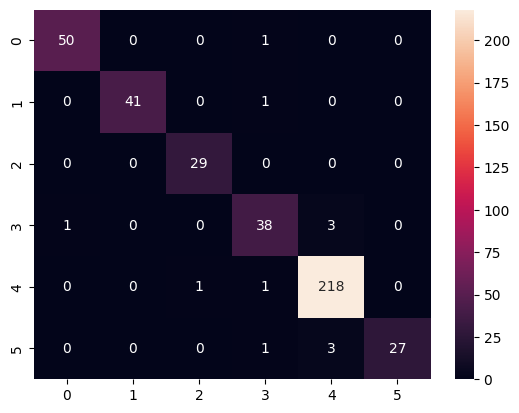

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
torch.autograd.set_detect_anomaly(True)

train_data = TensorDataset(encoded_train_texts['input_ids'], encoded_train_texts['attention_mask'], torch.tensor(train_df['label'].values))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

validation_data = TensorDataset(encoded_test_texts['input_ids'], encoded_test_texts['attention_mask'], torch.tensor(test_df['label'].values))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=32)

optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_values = []
loss_fn = torch.nn.CrossEntropyLoss()


for epoch in range(0, epochs):
    t0 = time.time()
    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device).long()

        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss = loss_fn(logits, b_labels)
        loss.backward(retain_graph=True)
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    print(f"Average training loss: {avg_train_loss}")
    print(f"Training epoch took: {time.time() - t0}")


model.eval()

predictions, true_labels = [], []

t0 = time.time()

for batch in validation_dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device).long()

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

print(f"Validation took: {time.time() - t0}")

flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
accuracy = accuracy_score(flat_true_labels, flat_predictions)

print(f"Accuracy: {accuracy}")

report = classification_report(flat_true_labels, flat_predictions, output_dict=True)

print(f"Precision: {report['macro avg']['precision']}")
print(f"Recall: {report['macro avg']['recall']}")
print(f"F1-score: {report['macro avg']['f1-score']}")

confusion_mat = confusion_matrix(flat_true_labels, flat_predictions)
sns.heatmap(confusion_mat, annot=True, fmt='d')
plt.show()